LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [4]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(37)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.Data Load

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [6]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Pre-processing

## 1.1 EDA
1. `Y_Quality` and `X features`: 
    - NOT high correlation, yet  

In [7]:
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

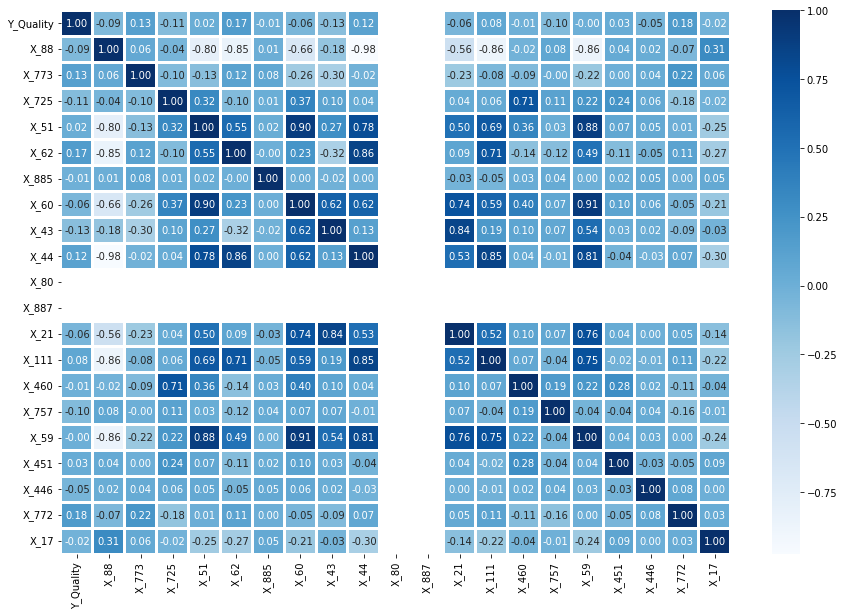

In [8]:
# heatmap: `random X features` and `Y_Quality` correlation 
import random
a = ['Y_Quality']

for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

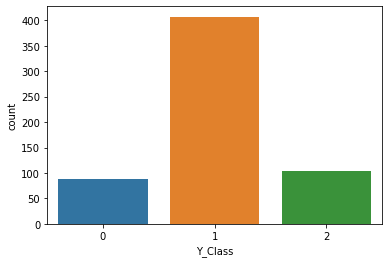

In [9]:
# UNBALANCED data --> metrics: precision, recall, f1-score 
sns.countplot(x='Y_Class', data=train_df);

## 1.2 Merge & Encoding
1. Merge `LINE` & `PRODUCT_CODE` & `Y_Class`columns by JOIN function
    - set the joined column name as `line_pcode_class`
2. Label encoding 
    - encode qualitative into quantitative

In [10]:
train_df['Y_Class'] = train_df['Y_Class'].astype(str)

col = ['Y_Class', 'LINE', 'PRODUCT_CODE']
train_df['line_pcode_class'] = train_df[col].apply(lambda row: ':'.join(row.values), axis=1)
train_df = train_df.drop(columns=['LINE', 'PRODUCT_CODE'])

print(train_df['line_pcode_class'].value_counts())

1:T100306:T_31    144
1:T100304:T_31    141
1:T050304:A_31     37
1:T010306:A_31     37
1:T010305:A_31     35
0:T050304:A_31     30
2:T010306:A_31     27
2:T050307:A_31     22
0:T100304:T_31     17
2:T100306:T_31     16
2:T100304:T_31     14
0:T010305:A_31     13
2:T050304:A_31     11
2:T010305:A_31     11
0:T050307:A_31     11
0:T100306:T_31     11
1:T050307:A_31      9
0:T010306:A_31      6
1:T100304:O_31      3
2:T100306:O_31      2
1:T100306:O_31      1
Name: line_pcode_class, dtype: int64


In [11]:
# Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['line_pcode_class']

for i in col:
    train_df[i] = encoder.fit_transform(train_df[i])

# correlation
print(train_df[['Y_Quality', 'line_pcode_class']].corr()) 

                  Y_Quality  line_pcode_class
Y_Quality          1.000000          0.689504
line_pcode_class   0.689504          1.000000


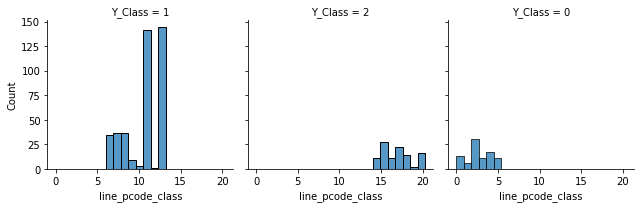

In [12]:
# line_pcode & Y_Class  
# sns.countplot(train_df, col='Y_Class', hue='line_pcode_class');
f = sns.FacetGrid(train_df, col="Y_Class")  
f.map_dataframe(sns.histplot, x="line_pcode_class", binwidth=0.9);  

## 1.3 Missing Values

In [13]:
# 1) features that have only 'NaN' without any recorded values 
## Total 81 features only have 'NaN' 
miss_dic = train_df.isnull().sum().to_dict()
all_NaN = pd.DataFrame({i for i in miss_dic if miss_dic[i]==598})
all_NaN_name = list(all_NaN[0])  # all_NaN features name in list 
print(len(all_NaN_name))

82


In [14]:
all_NaN2 = pd.DataFrame(np.zeros((82,82)), columns=list(all_NaN[0]))

for i in all_NaN_name: 
    train_df[i] = train_df[i].apply(lambda x: 0)
train_df.X_2686.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [21]:
xs = list(train_df.iloc[:, 6:].columns)
a = train_df.loc[train_df['line_pcode_class']==1]
for i in xs: 
    m = a.median()    
# a.fillna(a.median(), inplace=True)
 
    # a.fillna(a.mean(), inplace=True)
median = m.median()

In [22]:
a.fillna(median, inplace=True)
a

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode_class
67,0,0.513135,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,...,20.979167,20.979167,20.979167,20.979167,20.979167,0,0,0,0,1
68,0,0.517938,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,...,20.979167,20.979167,20.979167,20.979167,20.979167,0,0,0,0,1
78,0,0.524183,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,...,20.979167,20.979167,20.979167,20.979167,20.979167,0,0,0,0,1
294,0,0.522121,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,...,20.979167,20.979167,20.979167,20.979167,20.979167,0,0,0,0,1
333,0,0.524487,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,...,20.979167,20.979167,20.979167,20.979167,20.979167,0,0,0,0,1
585,0,0.515214,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,20.979167,...,20.979167,20.979167,20.979167,20.979167,20.979167,0,0,0,0,1


In [23]:
# 2) replace missing values with MEDIAN 
## based on 'line_pcode_class'
for i in range(21): 
    a = train_df.loc[train_df['line_pcode_class']==i]
    m = train_df.loc[train_df['line_pcode_class']==i].median()
    a.fillna(m.median(), inplace=True)

# 3) check is there still any missing value in train_df   
miss = train_df.isnull().sum().to_dict()
print({i for i in miss if miss[i] > 0})   

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return

KeyboardInterrupt: ignored

## 1.4 Scaling

[outlier Dection: IsolationForest](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

### 1.4.1 Outliers

In [78]:
xs = list(train_df.iloc[:, 6:].columns)

In [56]:
# outlier (replace 1Q, 3Q with MEDIAN)
def outlier(df):
    for col in xs: 
        q1 = train_df[col].quantile(0.25)
        q3 = train_df[col].quantile(0.75)
        median = train_df[col].quantile(0.50)

        train_df[col] = np.where(train_df[col]>q3, median, train_df[col])

train_df

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode_class
0,1,0.533433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.89,32.56,34.09,77.77,NaN,0,0,0,0,8
1,2,0.541819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.82,43.92,35.34,72.55,NaN,0,0,0,0,17
2,1,0.531267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.65,42.47,36.53,78.35,NaN,0,0,0,0,8
3,2,0.537325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.17,52.17,30.58,71.78,NaN,0,0,0,0,17
4,1,0.531590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.89,46.93,33.09,76.97,NaN,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,0.526546,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,13
594,0,0.524022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.07,50.89,55.10,66.49,1.0,0,0,0,0,2
595,0,0.521289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0,0,0,0,2
596,1,0.531375,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,10


In [18]:
train_df.describe()

,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode_class
count,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,349.000000,...,100.00000,100.000000,100.000000,100.00000,99.0,598.0,598.0,598.0,598.0,598.000000
mean,0.530896,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,41.469914,...,53.60770,49.606200,51.659800,66.64970,1.0,0.0,0.0,0.0,0.0,10.454849
std,0.007401,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,10.515032,...,8.13899,7.158917,8.913065,4.52781,0.0,0.0,0.0,0.0,0.0,4.572564
min,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,...,31.70000,32.560000,30.490000,61.67000,1.0,0.0,0.0,0.0,0.0,0.000000
25%,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,...,52.20000,42.160000,49.915000,63.64500,1.0,0.0,0.0,0.0,0.0,7.000000
50%,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,...,55.92500,51.460000,56.175000,65.14000,1.0,0.0,0.0,0.0,0.0,11.000000
75%,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,52.000000,...,58.97500,55.030000,57.175000,67.11500,1.0,0.0,0.0,0.0,0.0,13.000000
max,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,52.000000,...,68.66000,60.410000,59.930000,79.75000,1.0,0.0,0.0,0.0,0.0,20.000000


## 1.5 Test_df Preprocessing

In [58]:
# Merge 
col = ['LINE', 'PRODUCT_CODE']
test_df['line_pcode'] = test_df[col].apply(lambda row: ':'.join(row.values), axis=1)
test_df = test_df.drop(columns=['LINE', 'PRODUCT_CODE'])

# Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['line_pcode']

for i in col:
    test_df[i] = encoder.fit_transform(test_df[i])

In [59]:
# Missing Values
# 1) features that have only 'NaN' without any recorded values 
## Total 506 features only have 'NaN' 
miss_dic = test_df.isnull().sum().to_dict()
all_nan = pd.DataFrame({i for i in miss_dic if miss_dic[i]==310})
all_nan_name = list(all_nan[0])  # all_NaN features name in list 

for i in all_nan_name: 
    test_df[i].fillna(0, inplace=True)
test_df.X_2277.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [60]:
len(test_df['line_pcode'].unique())

8

In [61]:
len(list(test_df.loc[test_df['line_pcode']==3].columns))

2876

In [62]:
# 2) replace missing values with MEDIAN 
## based on 'line_pcode'

for i in range(8): 
    a = test_df.loc[test_df['line_pcode']==i]
    median = test_df.loc[test_df['line_pcode']==i].median()
    a.fillna(median, inplace=True)

# 3) check is there still any missing value in test_df
miss = test_df.isnull().sum().to_dict()
print({i for i in miss if miss[i] > 0})  

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inpla

{'X_1552', 'X_395', 'X_2020', 'X_1586', 'X_1602', 'X_2425', 'X_2653', 'X_1466', 'X_332', 'X_641', 'X_405', 'X_1699', 'X_1158', 'X_2519', 'X_1968', 'X_546', 'X_362', 'X_1764', 'X_812', 'X_1585', 'X_453', 'X_1769', 'X_1347', 'X_663', 'X_187', 'X_1667', 'X_1866', 'X_860', 'X_249', 'X_1310', 'X_2664', 'X_2633', 'X_1242', 'X_1365', 'X_443', 'X_2052', 'X_736', 'X_1161', 'X_1029', 'X_626', 'X_1199', 'X_388', 'X_1371', 'X_1915', 'X_566', 'X_2096', 'X_795', 'X_1851', 'X_1218', 'X_857', 'X_739', 'X_2496', 'X_802', 'X_973', 'X_1800', 'X_355', 'X_1717', 'X_2412', 'X_2777', 'X_1522', 'X_2780', 'X_1105', 'X_917', 'X_1244', 'X_2871', 'X_2526', 'X_43', 'X_1840', 'X_1039', 'X_2023', 'X_392', 'X_33', 'X_1765', 'X_1236', 'X_1528', 'X_1798', 'X_2792', 'X_1688', 'X_467', 'X_2658', 'X_2757', 'X_597', 'X_1642', 'X_932', 'X_2472', 'X_128', 'X_406', 'X_1935', 'X_312', 'X_51', 'X_222', 'X_1644', 'X_60', 'X_275', 'X_848', 'X_1248', 'X_1570', 'X_307', 'X_1215', 'X_363', 'X_709', 'X_858', 'X_1260', 'X_338', 'X_24'

In [63]:
# outlier (replace 1Q, 3Q with MEDIAN)
xs = list(test_df.iloc[:, 6:].columns)
def outlier(df):
    for col in xs: 
        q1 = test_df[col].quantile(0.25)
        q3 = test_df[col].quantile(0.75)
        median = test_df[col].quantile(0.50)

        test_df[col] = np.where(test_df[col]>q3, median, test_df[col])

test_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,243.000000,243.000000,243.0,243.0,243.000000,243.0,243.000000,243.000000,243.000000,243.0,...,34.000000,34.000000,34.000000,34.000000,39.000000,9.000000,9.000000,9.000000,9.000000,310.000000
mean,4.337449,94.448560,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.138710
std,16.624229,4.062582,0.0,0.0,0.445705,0.0,3.733199,0.110651,10.482308,0.0,...,4.431279,6.116252,3.419513,1.924128,0.160128,25.467305,20.078872,35.523689,19.514233,2.064522
min,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,41.630000,39.850000,47.820000,60.720000,0.000000,199.000000,214.600000,169.700000,191.900000,0.000000
25%,2.000000,91.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,50.095000,43.750000,52.170000,62.295000,1.000000,247.100000,253.900000,231.100000,232.800000,5.000000
50%,2.000000,95.000000,0.0,45.0,10.000000,0.0,50.000000,10.000000,52.000000,2.0,...,53.655000,51.175000,55.605000,63.170000,1.000000,258.700000,257.500000,261.700000,236.300000,5.000000
75%,2.000000,97.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,52.000000,2.0,...,55.957500,54.097500,56.642500,65.442500,1.000000,263.400000,261.300000,263.200000,239.700000,7.000000
max,154.000000,102.000000,0.0,45.0,11.000000,0.0,67.000000,11.000000,52.000000,2.0,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


# 2.Modeling_ML

In [ ]:
X_train = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP','Y_Class','Y_Quality'])
y_train = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

In [ ]:
test_x.isnull().sum()

LINE            0
PRODUCT_CODE    0
X_1             0
X_2             0
X_3             0
               ..
X_2871          0
X_2872          0
X_2873          0
X_2874          0
X_2875          0
Length: 2877, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=37)

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['LINE' ,'PRODUCT_CODE']

for i in col:
    train_x[i] = encoder.fit_transform(train_x[i])
    val_x[i] = encoder.fit_transform(val_x[i])
    test_x[i] = encoder.fit_transform(test_x[i])

train_df.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE            int64
               ...   
X_2871        float64
X_2872          int64
X_2873          int64
X_2874          int64
X_2875          int64
Length: 2881, dtype: object

## 2.1 Random Forest

In [66]:
# RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)
# print('Done')

In [149]:
X_train = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP','Y_Class','Y_Quality'])
y_train = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

In [150]:
test_x.isnull().sum()

LINE            0
PRODUCT_CODE    0
X_1             0
X_2             0
X_3             0
               ..
X_2871          0
X_2872          0
X_2873          0
X_2874          0
X_2875          0
Length: 2877, dtype: int64

In [151]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=37)

In [152]:
train_y

240    2
185    1
315    2
410    0
396    1
      ..
451    1
22     0
437    1
251    1
363    0
Name: Y_Class, Length: 448, dtype: int64

In [153]:
RF_model = RandomForestClassifier()

In [154]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
240,1,0,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
185,4,2,2.0,97.0,0.0,45.0,11.0,0.0,45.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
315,2,0,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,53.4250,55.9250,40.600,56.5900,65.12,1.0,0,0,0,0
410,0,0,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
396,5,2,2.0,96.0,0.0,45.0,10.0,0.0,51.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,5,2,1.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
22,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
437,1,0,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
251,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0


In [155]:
fitted = RF_model.fit(train_x, train_y) 

In [156]:
print(fitted.score(train_x, train_y))
print(fitted.score(val_x, val_y))

1.0
0.7666666666666667


In [157]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=37, shuffle=False)

# clf = RandomForestClassifier(max_depth=2, random_state=37)
# clf.fit(X,y)
# print(clf.predict([[0,0,0,0]]))

# 3.Modeling_DL

# 4.Model Comparison

# 5.Inference
- finally, performs perdiction for test set

In [158]:
test_x.describe()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,310.000000,310.000000,310.000000,310.000000,310.0,310.0,310.000000,310.0,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,3.941935,1.554839,3.832258,94.567742,0.0,45.0,10.212903,0.0,48.812903,10.009677,...,51.838129,53.584774,51.045516,55.451161,63.239774,0.996774,258.389032,257.337097,261.165806,236.083548
std,1.344959,0.825499,14.743467,3.602443,0.0,0.0,0.410022,0.0,3.362244,0.098055,...,0.891092,1.461929,2.032641,1.200629,0.659572,0.056796,4.476202,3.365744,6.499698,3.380980
min,0.000000,0.000000,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,44.410000,41.630000,39.850000,47.820000,60.720000,0.000000,199.000000,214.600000,169.700000,191.900000
25%,4.000000,2.000000,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,51.810000,53.655000,51.175000,55.605000,63.170000,1.000000,258.700000,257.500000,261.700000,236.300000
50%,4.000000,2.000000,2.000000,95.000000,0.0,45.0,10.000000,0.0,50.000000,10.000000,...,51.810000,53.655000,51.175000,55.605000,63.170000,1.000000,258.700000,257.500000,261.700000,236.300000
75%,5.000000,2.000000,2.000000,96.000000,0.0,45.0,10.000000,0.0,50.000000,10.000000,...,51.810000,53.655000,51.175000,55.605000,63.170000,1.000000,258.700000,257.500000,261.700000,236.300000
max,5.000000,2.000000,154.000000,102.000000,0.0,45.0,11.000000,0.0,67.000000,11.000000,...,58.060000,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000


In [159]:
preds = RF_model.predict(test_x)
print('Done.')

Done.


In [160]:
preds

array([2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

# 6.Submit

In [162]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  